In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import MNLogit

import warnings 
warnings.filterwarnings("ignore")

In [2]:
path = os.path.join("MODELING.xlsx")

# Read the Excel file
df = pd.read_excel(path)

# Display the first few rows
df.head(2)

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,...,0.000178,0.384454,0.365857,1.605769,7.166667,0.177778,8.950214,0.000015,42520.380790,0.595068
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,...,0.002708,0.384454,0.365857,22.028846,30.833333,42.805556,95.667735,0.000161,42934.591629,0.585840


In [3]:
df.keys()

Index(['year', 'nuts3_name', 'country', 'questioncount', 'answercount',
       'upvotecount', 'downvotecount', 'commentcount', 'nuts3_code',
       'EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'POP (THS)', 'activity',
       'activity_per_cap', 'CAGR', 'CAGR_per_cap', 'experts', 'innovators',
       'late_adopters', 'programmers_total', 'programmer_density',
       'GDP_per_cap', 'EMP_per_cap'],
      dtype='object')

## Create Excess Programming Literacy Rate 

The concept of the Excess Programming Literacy (EPL) Rate is to evaluate and compare regional programming proficiency against a sophisticated benchmark. This benchmark is established through a Random Forest model that assimilates critical socioeconomic indicators, including employment rates, population figures, and GDP metrics. The EPL serves a dual purpose:

1. **Alignment Assessment:** It acts as a tool to assess the extent to which regions conform to the expected levels of programming activity, as predicted by our model. This comparison is pivotal in understanding how certain regions perform in terms of programming literacy relative to what would be anticipated based on their economic and demographic profiles.

2. **Divergence Identification:** More significantly, the EPL Rate is engineered to highlight regions demonstrating anomalous trends. It identifies areas where actual programming activity either significantly exceeds or falls short of model predictions. Such divergence is crucial for recognizing unique regional characteristics or external factors influencing programming literacy beyond the standard economic and demographic parameters.

In essence, the EPL Rate is not just a measure of regional programming skills; it's a comprehensive analytical framework that provides deeper insights into the interplay between programming literacy and key economic indicators, aiding in more informed decision-making and strategic planning in the realm of educational and technological development.

In [4]:
# Selecting relevant features and target
features = ['EMP (THS)', 'POP (THS)', 'GDP_per_cap', 'EMP_per_cap']
target = 'activity'

# Defining features (X) and target variable (y)
X = df[features]
y = df[target]

# Creating the Random Forest Regression model
rf_model = RandomForestRegressor(random_state=42)

# Train-test split evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Train-Test Split Evaluation:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, y_pred, squared=False))
print("R-squared (R²):", r2_score(y_test, y_pred))

# 5-fold Cross-validation
print("\n5-Fold Cross-Validation:")
mae_scores = -cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(-cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error'))
r2_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
print("Cross-Validated MAE scores:", mae_scores)
print("Mean MAE:", np.mean(mae_scores))
print("Cross-Validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Cross-Validated R² scores:", r2_scores)
print("Mean R²:", np.mean(r2_scores))

Train-Test Split Evaluation:
Mean Absolute Error (MAE): 934.9709987357776
Root Mean Squared Error (RMSE): 2933.1617816012176
R-squared (R²): 0.9189370384148831

5-Fold Cross-Validation:
Cross-Validated MAE scores: [1198.60115234  783.22628003 1829.91820063 2070.91062405 2426.22702911]
Mean MAE: 1661.776657232313
Cross-Validated RMSE scores: [2908.25735033 1461.52256369 6068.2668733  8595.83086365 6969.22202526]
Mean RMSE: 5200.6199352453605
Cross-Validated R² scores: [0.66084066 0.57237753 0.04010479 0.39311287 0.39758307]
Mean R²: 0.41280378425985126


- The model shows a good fit in the train-test split evaluation but exhibits potential overfitting, as indicated by the cross-validation results.
- The significant drop in performance in cross-validation (especially in R²) suggests that the model's predictions are not as reliable when generalized to new data.
- The inconsistencies in MAE and RMSE across different folds further suggest that the model's performance might vary with different data characteristics.

Nevertheless I continue to compute the residuals - the differences between the actual and predicted values. These residuals are visualized in two ways: a scatter plot of residuals versus observed values to identify any patterns, and a histogram to examine the distribution of residuals, which helps in understanding the model's accuracy and consistency. 

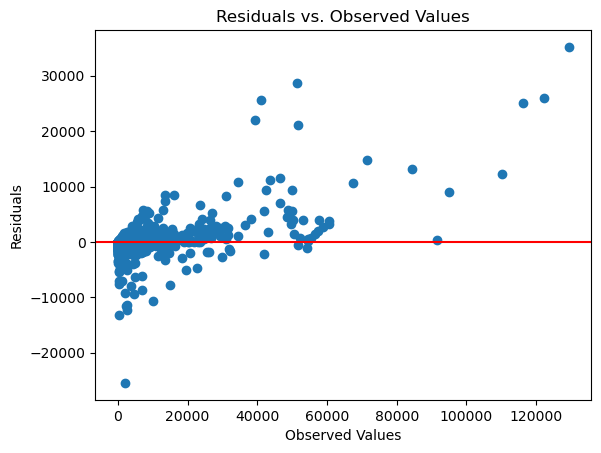

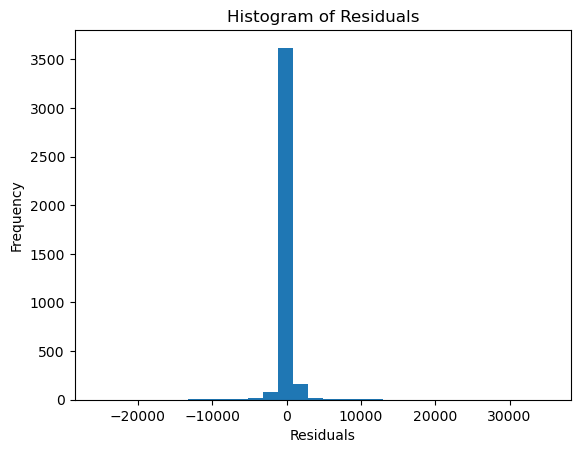

In [5]:
# Predicting 'activity' for the entire dataframe
df['predicted'] = rf_model.predict(df[features])

# Calculating the residuals
df['residuals'] = df['activity'] - df['predicted']

# Plotting residuals
plt.scatter(df['activity'], df['residuals'])
plt.title('Residuals vs. Observed Values')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals
plt.hist(df['residuals'], bins=30)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

As the results of my regression models using EPL were inconclusive, I did not mention the use of this metric in my thesis. Nevertheless, I also applied them in Step 3 and 4.

# Does Programming Literacy affect Economic Resilience?

**Step 1:** Calculate ERI for the resistance phase (2008-2013):

This code calculates a regional economic resilience index, termed as the EU-based Regional Economic Resilience (b_eures), by comparing employment changes between 2008 and 2013 at both the EU and regional levels. Initially, data for the years 2008 and 2013 are selected and aggregated to compute the total employment change at the EU level. The change rate in employment for each NUTS-3 region within the same timeframe is then calculated. This regional change rate is merged into the main dataset, and the b_eures index is computed by normalizing the difference between regional and EU-level employment changes relative to the EU change. Finally, regions are flagged as resilient or unresilient based on whether their b_eures value is non-negative.

In [7]:
# Selecting relevant data for the years 2008 and 2013
df_2008 = df[df['year'] == 2008]
df_2013 = df[df['year'] == 2013]

# Aggregating total employment at the EU level for 2008 and 2013
total_emp_2008 = df_2008['EMP (THS)'].sum()
total_emp_2013 = df_2013['EMP (THS)'].sum()

# Calculating the rate of change in employment at the EU level
eu_change = (total_emp_2013 - total_emp_2008) / total_emp_2008

# Calculating the rate of change in employment for each NUTS-3 region for 2008 and 2013
grouped_df = df.groupby(['nuts3_name', 'year'])['EMP (THS)'].sum().unstack()
grouped_df['region_change'] = (grouped_df[2013] - grouped_df[2008]) / grouped_df[2008]

# Adding the rate of change of each region to the main DataFrame
df = df.merge(grouped_df['region_change'], left_on='nuts3_name', right_index=True)

# Calculating the EU-based regional economic resilience (b_eures)
df['b_eures'] = (df['region_change'] - eu_change) / abs(eu_change)

# Flagging resilient and unresilient countries
df['resilience_flag'] = (df['b_eures'] >= 0).astype(int)

In [19]:
# Counting the values in the 'resilience_flag' column and calculating percentages
resilience_counts = df['resilience_flag'].value_counts()
resilience_percentages = df['resilience_flag'].value_counts(normalize=True) * 100

print("Counts:\n", resilience_counts)
print("\nPercentages:\n", resilience_percentages)

Counts:
 1    2561
0    1391
Name: resilience_flag, dtype: int64

Percentages:
 1    64.802632
0    35.197368
Name: resilience_flag, dtype: float64


**Results:**
- 2,561 regions are flagged as resilient (represented by '1') and 1,391 regions flagged as unresilient (represented by '0'). 
- In percentage terms, approximately 64.8% of the regions are classified as resilient, demonstrating a majority where the regional economic resilience is positive or equal to zero. 
- Conversely, about 35.2% of the regions are classified as unresilient, indicating a significant portion where the regional economic resilience is negative. 
- These figures suggest a predominant trend of resilience in the analyzed regions, but also highlight that a substantial number of regions do not meet the resilience criteria.

**Step 2:** Caclulate ERI for the recovery phase (2014-2015): We repeat the same code for the pre-defined recovery years 2014-2015

In [8]:
# Selecting relevant data for the years 2014 and 2015
df_2014 = df[df['year'] == 2014]
df_2015 = df[df['year'] == 2015]

# Aggregating total employment at the EU level for 2014 and 2015
total_emp_2014 = df_2014['EMP (THS)'].sum()
total_emp_2015 = df_2015['EMP (THS)'].sum()

# Calculating the rate of change in employment at the EU level
eu_change2 = (total_emp_2015 - total_emp_2014) / total_emp_2014

# Calculating the rate of change in employment for each NUTS-3 region for 2014 and 2015
grouped_df = df.groupby(['nuts3_name', 'year'])['EMP (THS)'].sum().unstack()
grouped_df['region_change2'] = (grouped_df[2015] - grouped_df[2014]) / grouped_df[2014]

# Adding the rate of change for each region to the main DataFrame
df = df.merge(grouped_df['region_change2'], left_on='nuts3_name', right_index=True)

# Calculating the EU-based regional economic recovery (b_eurec)
df['b_eurec'] = (df['region_change2'] - eu_change2) / abs(eu_change2)
df['recovery_flag'] = (df['b_eurec'] >= 0).astype(int)

In [20]:
# Counting the values in the 'resilience_flag' column and calculating percentages
resilience_counts = df['recovery_flag'].value_counts()
resilience_percentages = df['recovery_flag'].value_counts(normalize=True) * 100

print("Counts:\n", resilience_counts)
print("\nPercentages:\n", resilience_percentages)

Counts:
 0    2639
1    1313
Name: recovery_flag, dtype: int64

Percentages:
 0    66.776316
1    33.223684
Name: recovery_flag, dtype: float64


- 2,639 regions are flagged as not experiencing economic recovery (represented by '0'), which constitutes approximately 66.78% of the total regions analyzed. 
- 1,313 regions, or about 33.22%, are flagged as experiencing economic recovery (represented by '1'). 
- This distribution indicates that a majority of the regions did not meet the criteria for economic recovery during this period, suggesting that these areas possibly faced challenges or slower growth in employment relative to the overall EU change. 
- The smaller proportion of regions marked as recovering highlights areas where economic conditions have improved, potentially reflecting effective economic policies, resilience, or other favorable factors during this timeframe.

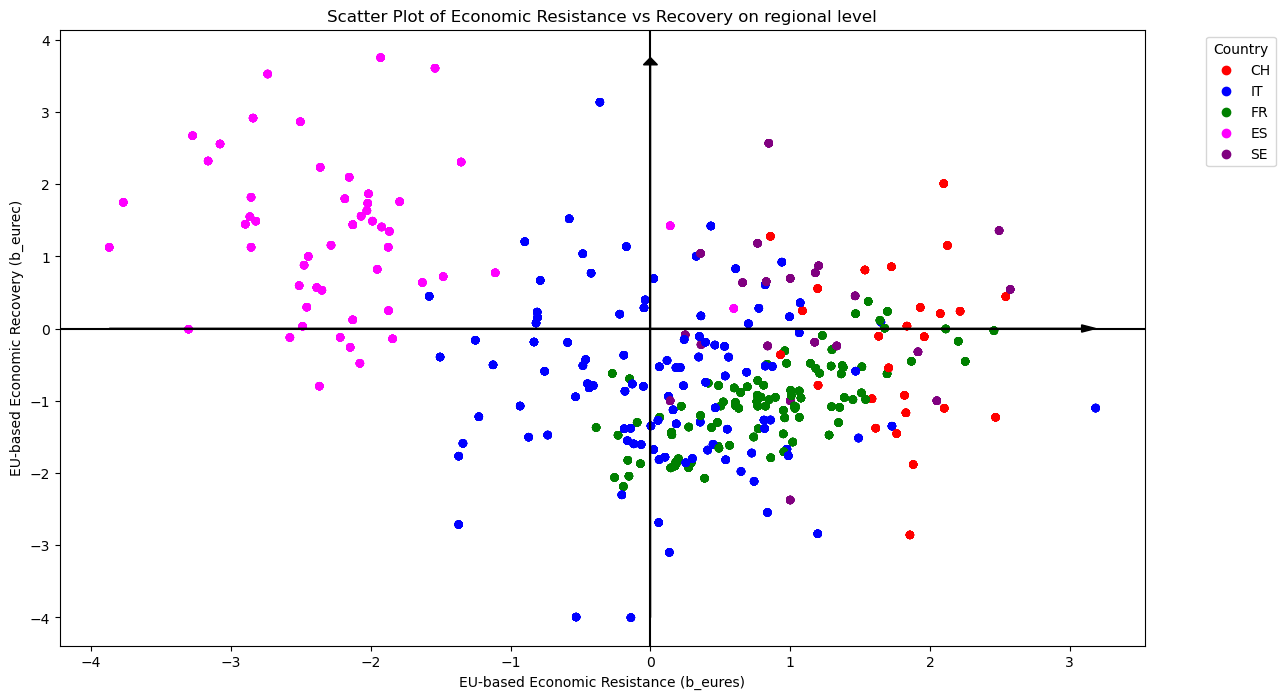

In [9]:
# Define a custom color mapping dictionary
color_mapping = {
    'CH': 'red',
    'IT': 'blue',
    'ES': 'magenta',
    'SE': 'purple',
    'FR': 'green'}
    
# Apply the custom colors to the 'country' column in your DataFrame
df['color'] = df['country'].map(color_mapping)

# Now, let's create the scatter plot based on the actual DataFrame
plt.figure(figsize=(14, 8))

# Using scatterplot from seaborn to create the scatter points without shapes
scatter_plot = sns.scatterplot(data=df, x='b_eures', y='b_eurec', hue='country', palette=color_mapping, legend='full', edgecolor='none')

# Add horizontal and vertical lines along the 0 values
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

# Add arrows along these lines to indicate direction
plt.arrow(0, df['b_eurec'].min(), 0, df['b_eurec'].max() - df['b_eurec'].min(),
          length_includes_head=True, head_width=0.1, head_length=0.1, fc='black', ec='black')
plt.arrow(df['b_eures'].min(), 0, df['b_eures'].max() - df['b_eures'].min(), 0,
          length_includes_head=True, head_width=0.1, head_length=0.1, fc='black', ec='black')

# Remove the shapes from the legend and adjust it to show only colors and corresponding country names
handles, labels = scatter_plot.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = handles[:len(unique_labels)]
legend_dict = dict(zip(unique_labels, unique_handles))
plt.legend(legend_dict.values(), legend_dict.keys(), title='Country', bbox_to_anchor=(1.05, 1), loc=2)

# Set the title and labels
plt.title('Scatter Plot of Economic Resistance vs Recovery on regional level')
plt.xlabel('EU-based Economic Resistance (b_eures)')
plt.ylabel('EU-based Economic Recovery (b_eurec)')

# Show the plot
plt.show()


- Regions in the top right quadrant show both strong economic resistance and recovery, suggesting robust regional economies that have withstood challenges and bounced back effectively.
- Regions in the bottom left quadrant exhibit weak resistance and recovery, indicating vulnerabilities in both aspects of their economies.
- Regions that fall along the vertical axis (near b_eures = 0) show average resistance, with their recovery rates varying. Those above the horizontal axis have recovered better than the EU average, and those below have fared worse.
- The distribution of countries varies across quadrants, indicating that economic resistance and recovery are not uniform across the regions of the represented countries. 
- Some countries' regions, like those of Italiy (IT), are spread across all quadrants, showing varied economic performance.


**Next Step:** I aggregate the df by each country, computing the average values of the economic resistance ('b_eures') and recovery ('b_eurec') indices. The results are plotted again in form of a scatter plot 

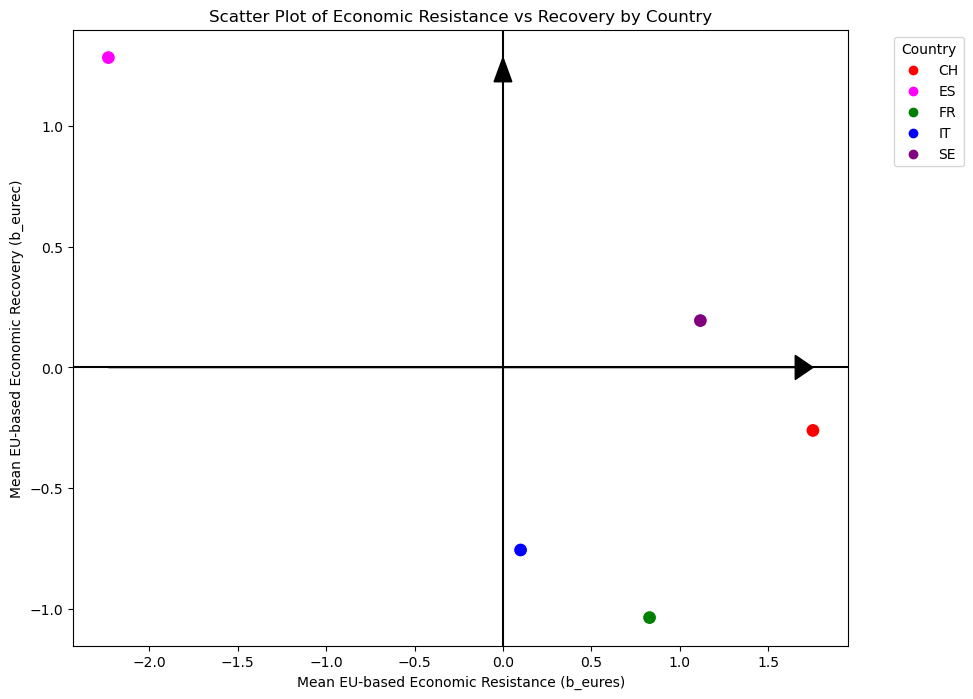

In [10]:
# Group the DataFrame by country and calculate the mean for 'b_eures' and 'b_eurec'
df_grouped = df.groupby('country').agg({'b_eures': 'mean', 'b_eurec': 'mean'}).reset_index()
df_grouped['color'] = df_grouped['country'].map(color_mapping)

# Create a scatter plot for the grouped data
plt.figure(figsize=(10, 8))

# Using scatterplot from seaborn to create the scatter points
scatter_plot = sns.scatterplot(data=df_grouped, x='b_eures', y='b_eurec', hue='country',palette=color_mapping, s=100)

# Add horizontal and vertical lines along the 0 values
plt.axhline(0, color='black', linewidth=1.5)
plt.axvline(0, color='black', linewidth=1.5)

# Add arrows along these lines to indicate direction
plt.arrow(0, df_grouped['b_eurec'].min(), 0, df_grouped['b_eurec'].max() - df_grouped['b_eurec'].min(),
          length_includes_head=True, head_width=0.1, head_length=0.1, fc='black', ec='black')
plt.arrow(df_grouped['b_eures'].min(), 0, df_grouped['b_eures'].max() - df_grouped['b_eures'].min(), 0,
          length_includes_head=True, head_width=0.1, head_length=0.1, fc='black', ec='black')

# Set the title and labels
plt.title('Scatter Plot of Economic Resistance vs Recovery by Country')
plt.xlabel('Mean EU-based Economic Resistance (b_eures)')
plt.ylabel('Mean EU-based Economic Recovery (b_eurec)')

# Adjust the legend
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc=2)

# Show the plot
plt.show()

**Step 3:** Calculate the impact of (excess) programming literacy on resistance:

For this step and Step 4 the code's purpose is to evaluate the predictive power of different programming literacy determinants on regional resistance and in step 4 recovery by running logistic regression analyses and cross-validating the results for accuracy.

In [11]:
def run_logistic_regression(df, variable):

    y = df['resilience_flag']
    X = sm.add_constant(df[[variable]])

    model = sm.Logit(y, X)
    result = model.fit(disp=0)
    print(f"Results using {variable}:")
    print(result.summary())

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    accuracy_list = [sm.Logit(y.iloc[train_index], X.iloc[train_index]).fit(disp=0).predict(X.iloc[test_index]).round().eq(y.iloc[test_index]).mean() for train_index, test_index in kf.split(X)]

    print("Accuracy for each fold: ", accuracy_list)
    print("Mean accuracy: ", np.mean(accuracy_list))
    print("\n") 

# List of variables to test
variables = ['activity', 'residuals','programmer_density', 'programmers_total']

# Run logistic regression for each variable
for var in variables:
    run_logistic_regression(df, var)

Results using activity:
                           Logit Regression Results                           
Dep. Variable:        resilience_flag   No. Observations:                 3952
Model:                          Logit   Df Residuals:                     3950
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                0.007123
Time:                        01:02:38   Log-Likelihood:                -2545.2
converged:                       True   LL-Null:                       -2563.5
Covariance Type:            nonrobust   LLR p-value:                 1.512e-09
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5261      0.037     14.398      0.000       0.454       0.598
activity    3.952e-05   8.06e-06      4.904      0.000    2.37e-05    5.53e-05
Accuracy for each fold:  [0.

**Summary Results:** The logistic regression analysis across different programming literacy indicators shows that 'programmer_density' has the highest pseudo R-squared value, indicating it may be the most significant predictor for regional economic resistance among the variables tested. All variables have similar mean accuracies of approximately 64.8%, with 'activity' and 'programmers_total' also being statistically significant predictors but with lower pseudo R-squared values, suggesting they have less predictive power than 'programmer_density'. The variable 'residuals' has the lowest pseudo R-squared and a marginally lower mean accuracy, indicating the least predictive power for resistance.

**Step 4:** Repeat for recovery phase

In [12]:
def run_logistic_regression(df, variable):

    y = df['recovery_flag']
    X = sm.add_constant(df[[variable]])

    model = sm.Logit(y, X)
    result = model.fit(disp=0)
    print(f"Results using {variable}:")
    print(result.summary())

    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    accuracy_list = [sm.Logit(y.iloc[train_index], X.iloc[train_index]).fit(disp=0).predict(X.iloc[test_index]).round().eq(y.iloc[test_index]).mean() for train_index, test_index in kf.split(X)]

    print("Accuracy for each fold: ", accuracy_list)
    print("Mean accuracy: ", np.mean(accuracy_list))
    print("\n") 

# List of variables to test
variables = ['activity', 'residuals','programmer_density', 'programmers_total']

# Run logistic regression for each variable
for var in variables:
    run_logistic_regression(df, var)

Results using activity:
                           Logit Regression Results                           
Dep. Variable:          recovery_flag   No. Observations:                 3952
Model:                          Logit   Df Residuals:                     3950
Method:                           MLE   Df Model:                            1
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                 0.01639
Time:                        01:02:52   Log-Likelihood:                -2471.3
converged:                       True   LL-Null:                       -2512.5
Covariance Type:            nonrobust   LLR p-value:                 1.135e-19
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8188      0.037    -22.056      0.000      -0.892      -0.746
activity    4.849e-05   6.41e-06      7.559      0.000    3.59e-05    6.11e-05
Accuracy for each fold:  [0.

**Summary Results:** 
Again, logistic regression results indicate 'programmer_density' as the strongest predictor for regional economic recovery with the highest pseudo R-squared and a mean accuracy of about 68.98%. 'Activity' and 'programmers_total' also show significant predictive power with similar mean accuracies of 68.22% and 68.12%, respectively, but 'activity' has a slightly higher pseudo R-squared. 'Residuals' are the least predictive with the lowest pseudo R-squared and a marginally lower mean accuracy of 66.78%.

**Step 5:** Assessing the impact of (excess) programming literacy on combined ERI (resistance + recovery)

In [13]:
#Create the 'RES_Group' column based on the conditions with direct assignment of numerical values
def classify_res_group_numeric(row):
    if row['b_eures'] < 0 and row['b_eurec'] < 0:
        return 1  # Group 1
    elif row['b_eures'] < 0 and row['b_eurec'] > 0:
        return 2  # Group 2
    elif row['b_eures'] > 0 and row['b_eurec'] < 0:
        return 3  # Group 3
    elif row['b_eures'] > 0 and row['b_eurec'] > 0:
        return 4  # Group 4
    else:
        return 0  # Unknown

df['RES_Group'] = df.apply(classify_res_group_numeric, axis=1)

# Selection of the independent variable 'programmer_density' and the dependent variable 'RES_Group'
X = df[['programmer_density']]
y = df['RES_Group']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create and adjust the multinomial logistic regression model
mnlogit_model = MNLogit(y, X)
mnlogit_result = mnlogit_model.fit()

# Show results
mnlogit_result.summary()

Optimization terminated successfully.
         Current function value: 1.175712
         Iterations 16


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              RES_Group   No. Observations:                 3952
Model:                        MNLogit   Df Residuals:                     3946
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                 0.04145
Time:                        01:02:56   Log-Likelihood:                -4646.4
converged:                       True   LL-Null:                       -4847.3
Covariance Type:            nonrobust   LLR p-value:                 8.939e-87
======================================================================================
       RES_Group=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.4410      0.072     -6.090      0.000      -0.583      -0.299
programmer_density  3514.6539    316.724     11.097      0.000    2893.887    4135.421
--------------------------------------------------------------------------------------
       RES_Group=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.6298      0.063     10.044      0.000       0.507       0.753
programmer_density  3142.7293    309.280     10.161      0.000    2536.551    3748.908
--------------------------------------------------------------------------------------
       RES_Group=4       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.1053      0.081    -13.725      0.000      -1.263      -0.947
programmer_density  4264.2190    316.047     13.492      0.000    3644.779    4883.659
======================================================================================
"""

In [35]:
df['RES_Group'] = df.apply(classify_res_group_numeric, axis=1)

# Selection of the independent variable 'activity' and the dependent variable 'RES_Group'
X = df[['activity']]
y = df['RES_Group']

X = sm.add_constant(X)
mnlogit_model = MNLogit(y, X)
mnlogit_result = mnlogit_model.fit()
mnlogit_result.summary()

Optimization terminated successfully.
         Current function value: 1.193177
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:              RES_Group   No. Observations:                 3952
Model:                        MNLogit   Df Residuals:                     3946
Method:                           MLE   Df Model:                            3
Date:                Wed, 20 Dec 2023   Pseudo R-squ.:                 0.02721
Time:                        05:16:47   Log-Likelihood:                -4715.4
converged:                       True   LL-Null:                       -4847.3
Covariance Type:            nonrobust   LLR p-value:                 6.850e-57
===============================================================================
RES_Group=2       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.2180      0.064     -3.392      0.001      -0.344      -0.092
activity        0.0004    4.2e-05      9.041      0.000       0.000       0.000
-------------------------------------------------------------------------------
RES_Group=3       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7794      0.056     13.869      0.000       0.669       0.890
activity        0.0004   4.17e-05      8.773      0.000       0.000       0.000
-------------------------------------------------------------------------------
RES_Group=4       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.6962      0.070     -9.940      0.000      -0.833      -0.559
activity        0.0004   4.19e-05      9.951      0.000       0.000       0.000
===============================================================================
"""

Finally, I created a composite Index per country. Switzerland has the highest overall rate, Sweden is second, then comes France, Italy and lastly, Spain

In [25]:
df['eurec+eures'] = (df['b_eurec'] + df['b_eures']) / 2
grouped_df = df.groupby('nuts3_name')['eurec+eures'].mean().reset_index()
grouped_df2 = df.groupby('country')['eurec+eures'].mean().reset_index()

In [22]:
grouped_df

,nuts3_name,eurec+eures
0,Aargau,0.934079
1,Agrigento,-0.179521
2,Ain,0.420490
3,Aisne,-0.854444
4,Albacete,-0.030298
...,...,...
297,Zug,1.139931
298,Zürich,1.289293
299,Ávila,-1.280386
300,Örebro County,1.705933


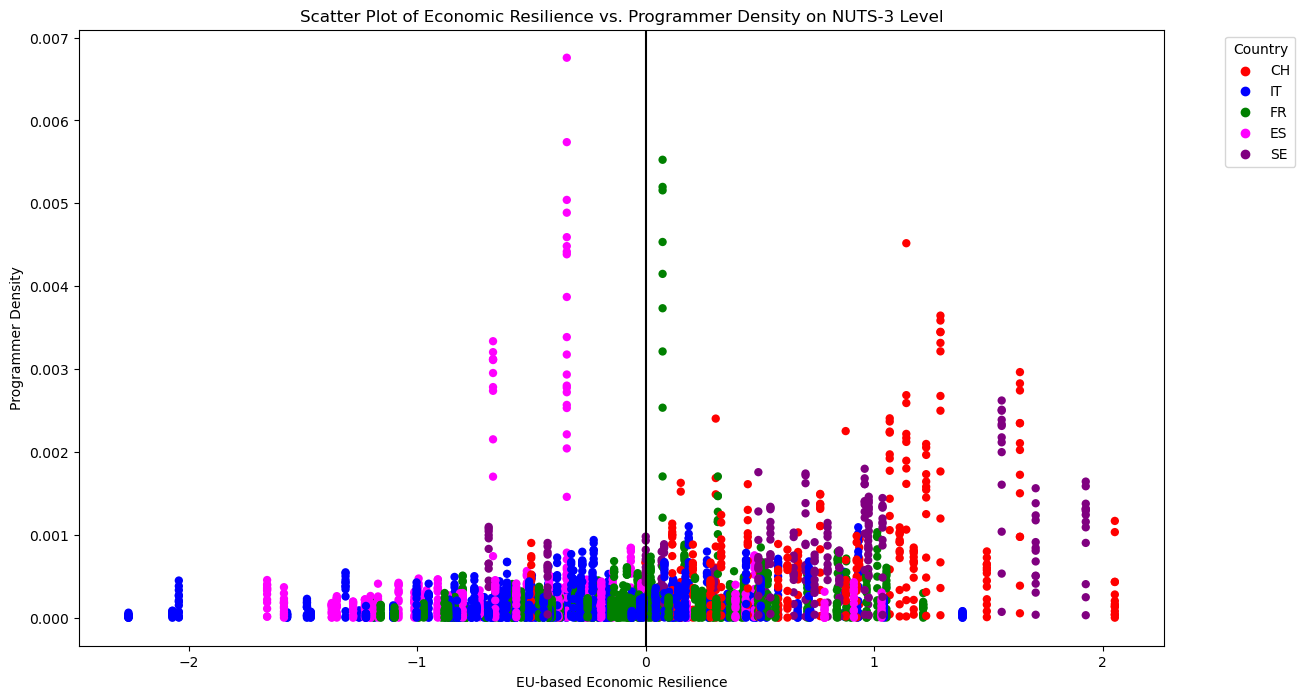

In [31]:
# Define a custom color mapping dictionary
color_mapping = {
    'CH': 'red',
    'IT': 'blue',
    'ES': 'magenta',
    'SE': 'purple',
    'FR': 'green'}
    
# Apply the custom colors to the 'country' column in your DataFrame
df['color'] = df['country'].map(color_mapping)

# Now, let's create the scatter plot based on the actual DataFrame
plt.figure(figsize=(14, 8))

# Using scatterplot from seaborn to create the scatter points without shapes
scatter_plot = sns.scatterplot(data=df, x='eurec+eures', y='programmer_density', hue='country', palette=color_mapping, legend='full', edgecolor='none')

# Add horizontal and vertical lines along the 0 values
plt.axvline(0, color='black', linewidth=1.5)


# Remove the shapes from the legend and adjust it to show only colors and corresponding country names
handles, labels = scatter_plot.get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))
unique_handles = handles[:len(unique_labels)]
legend_dict = dict(zip(unique_labels, unique_handles))
plt.legend(legend_dict.values(), legend_dict.keys(), title='Country', bbox_to_anchor=(1.05, 1), loc=2)

# Set the title and labels
plt.title('Scatter Plot of Economic Resilience vs. Programmer Density on NUTS-3 Level')
plt.xlabel('EU-based Economic Resilience')
plt.ylabel('Programmer Density')

# Show the plot
plt.show()